In [1]:
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import numpy as np

from amygdala_spiking.data import load_bids_group, epoch_sig
from amygdala_spiking.preproc import preprocess, preprocess_group

from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_variance
from neurodsp.plts import plot_time_series, plot_power_spectra

from fooof import FOOOFGroup
from fooof.objs.utils import combine_fooofs

from ndspflow.motif import MotifGroup
from ndspflow.optimize import refit, refit_group

## Time Resolved Motifs
This notebook examines and quantifies how motifs change over time. The motivation came from the failure of using motifs to accurately classify trial types using SVM-GAK. Previous worked showed this was possible using spectrogram features.

To extend motifs to a sliding window approach, this notebook computes motifs per 1s time window. This allows us to examine how the motif changes over time, in reference to a single motif found across all windows. Affine, and particularly a polynomial, transforms accurately quantifiy how much each windowed motif deviates from the mean motif.

In [2]:
# Load bids data
bids_dir = os.path.join(os.getcwd(), 'data_bids')

raw = load_bids_group(bids_dir)

Extracting parameters from data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_task-jokeit_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_task-jokeit_run-01_events.tsv.
Reading channel info from data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_task-jokeit_run-01_channels.tsv.
Reading electrode coords from data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_space-MNI152_electrodes.tsv.
Extracting parameters from data_bids/sub-02/ses-01/ieeg/sub-02_ses-01_task-jokeit_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from data_bids/sub-02/ses-01/ieeg/sub-02_ses-01_task-jokeit_run-01_events.tsv.
Reading channel info from data_bids/sub-02/ses-01/ieeg/sub-02_ses-01_task-jokeit_run-01_channels.tsv.
Reading electrode coords from data_bids/sub-02/ses-01/ieeg/sub-02_ses-01_space-MNI152_electrodes.tsv.
Extracting parameters from data_bids/sub-03/ses-01/ieeg/sub-03_ses-01_task-jokeit_run-01_ieeg.vhdr...
Setting channel info structure

In [3]:
preproc_data = preprocess_group(raw, 'lowpass', f_range=200)

100%|██████████| 9/9 [00:04<00:00,  2.20it/s]


In [4]:
fs = preproc_data['01']['fs']
epoch_types = preproc_data['01']['epoch_types']

In [5]:
sigs = []
for subj_key in preproc_data:
    
    _sigs = preproc_data[subj_key]['sigs']
    
    if 'mmAL1' in _sigs.keys():
        sig_key = 'mmAL1'
    elif 'mAL1' in _sigs.keys():
        sig_key = 'mAL1'
    else:
        continue
        
    sigs.append(_sigs[sig_key])
    
sigs = np.array(sigs)

In [61]:
for idx, sig in enumerate(sigs):
    sigs[idx] = normalize_variance(sig)

In [154]:
fgs = []
fgs_refit = []
imfs = []
pe_masks = []

drop_idxs = []
motif_group = []

for ind, sigs_subj in enumerate(sigs):
    
    sigs_subj = normalize_variance(sigs_subj, variance=1)
    
    # Specparam
    f_range = (1, 100)

    freqs, powers = compute_spectrum(sigs_subj, fs, f_range=f_range)

    fg = FOOOFGroup(verbose=False)

    fg.fit(freqs, powers, freq_range=f_range, n_jobs=-1)

    fgs.append(fg)
    
    # Refit
    fg_refit, imfs, pe_mask = refit_group(fg, sigs_subj, fs, f_range, power_thresh=0.1)

    # Remove imfs that aren't above 1/f
    imfs_filt = [imf[idx] for imf, idx in zip(imfs, pe_mask)]

    # Drop specparam models and imfs that don't have motifs
    fg_refit_filt = fg_refit.copy()

    drop_idx = [idx for idx, mask in enumerate(pe_mask) if not mask.any()]
    imfs_filt = [imf for imf, mask in zip(imfs_filt, pe_mask) if mask.any()]
    
    drop_idxs.append(drop_idx)
    pe_masks.append(pe_mask)
    
    fms = []
    for ind in range(len(fg_refit)):
        if ind not in drop_idx:
            fms.append(fg_refit.get_fooof(ind))

    fg_refit_filt = combine_fooofs(fms)

    # Compute motifs
    motif_epoch = MotifGroup(var_thresh=.01, corr_thresh=0.25, max_clusters=1, random_state=0)
    
    #motif_epoch.fit(fg_refit_filt, imfs_filt, fs, ttype='polynomial',
    #                n_jobs=2, progress='tqdm.notebook')
    _sigs = np.array([s for idx, s in enumerate(sigs_subj) if idx not in drop_idx])
    
    motif_epoch.fit(fg_refit_filt,  _sigs, fs, ttype='polynomial',
                    n_jobs=2, progress='tqdm.notebook')
    motif_group.append(motif_epoch)
    
    break

Computing Motifs:   0%|          | 0/17 [00:00<?, ?it/s]

In [155]:
from ndspflow.motif import extract
from ndspflow.motif.utils import motif_to_cycle

def track_motifs(fm, df_features, sig, n_windows,
                 index=None, ref=None, ttype='affine', random_state=None):
    
    # Upper limits
    uppers = np.linspace(0, len(sig), n_windows+1).astype(int)[1:]
    
    ends = df_features['sample_next_trough'].values
    
    motifs = []
    for lim in uppers:
        
        inds = np.where(ends < lim)[0]
        
        if len(inds) == 0:
            continue
        
        df_sub = df_features.iloc[inds]
        
        motif, _ = extract(fm, sig, fs, df_features=df_sub, min_clusters=1, 
                           max_clusters=1, min_n_cycles=1, use_thresh=False,
                           index=index, random_state=random_state)
        
        motif = motif[0][0]
        motifs.append(motif)
    
    if ref:
        
        motifs_trans = []
        tforms = []
        for motif in motifs:

            motif_trans, tform = motif_to_cycle(motif, ref, ttype)

            motifs_trans.append(motif_trans)
            tforms.append(tform)
        
    if ref:
        return motifs, motifs_trans, tforms
    
    return motifs

In [156]:
motif_group[0][0].sig

array([0.27569417, 0.35721614, 0.42170562, ..., 0.10110883, 0.08609747,
       0.0658041 ])

In [157]:
motifs, motif_trans, tforms = track_motifs(
    motif_group[0][0].fm,
    motif_group[0][0][0].df_features,
    motif_group[0][0].sig,
    20,
    index=0,
    ref = motif_group[0][0][0].motif,
    ttype='polynomial'
 )

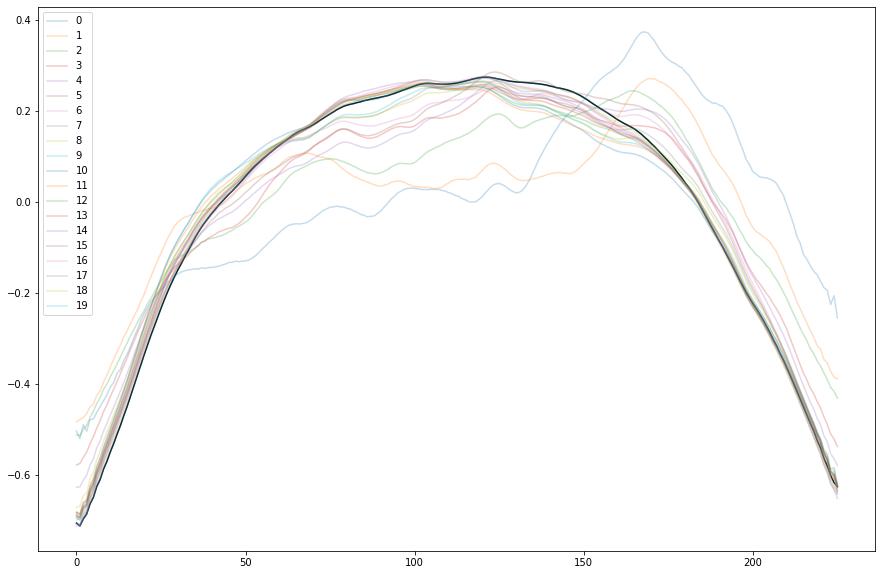

In [158]:
fig = plt.figure(figsize=(15, 10))

plt.plot(motif_group[0][0][0].motif[0], color='k')

for idx, m in enumerate(motifs):
    plt.plot(m, alpha=.25, label=str(idx))
plt.legend()
plt.show()

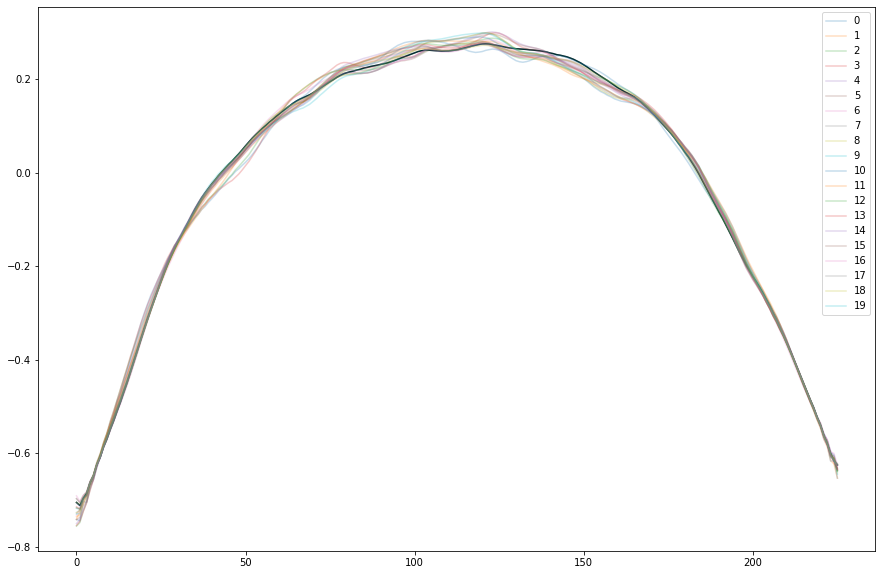

In [159]:
fig = plt.figure(figsize=(15, 10))

plt.plot(motif_group[0][0][0].motif[0], color='k')

for idx, m in enumerate(motif_trans):
    plt.plot(m, alpha=.25, label=str(idx))
plt.legend()
plt.show()

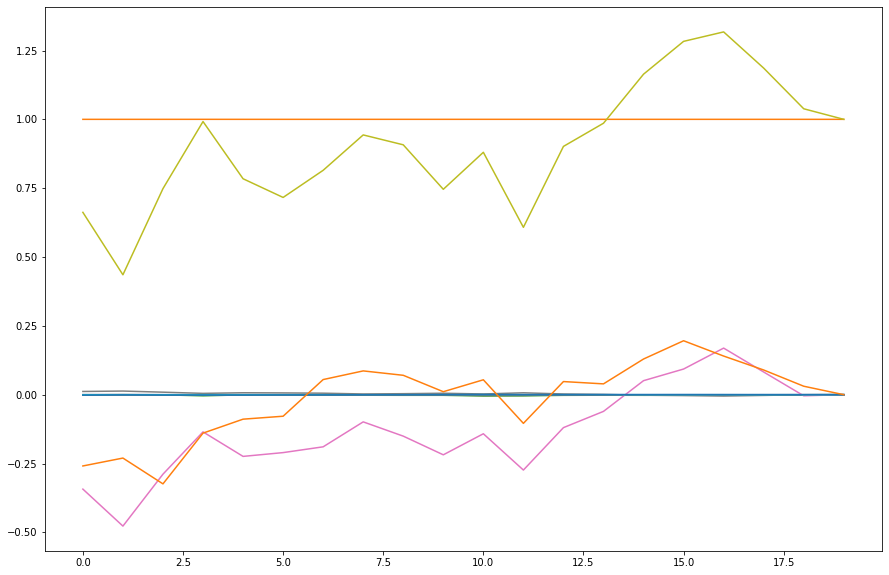

In [167]:
fig = plt.figure(figsize=(15, 10))
params = np.array([i.params for i in tforms]).reshape(20, -1)

for i in range(params.shape[-1]):
    plt.plot(params[:, i])

In [161]:
for idx, motif in enumerate(motifs):
    motifs[idx]-= np.min(motif)

motifs = np.array(motifs)
motifs = motifs.flatten()
motifs -= np.mean(motifs)

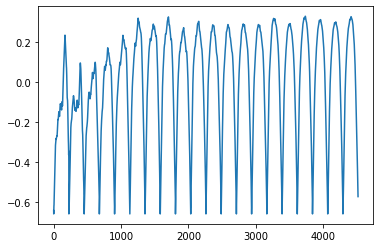

In [162]:
plt.plot(motifs)

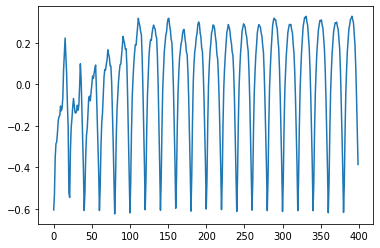

In [163]:
from scipy.signal import resample

plt.plot(resample(motifs, 400))